<a href="https://colab.research.google.com/github/SiriRRR/590-project/blob/main/final_model_results_and_model_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q transformers torch
 !pip install datasets
 !pip install evaluate
 !pip install rouge_score

In [2]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers.tokenization_utils_base import BatchEncoding
from typing import List, Tuple
from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_metric

In [4]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
 
K = len(labels)

# load summary results generate by text summarization model
df_0 = pd.read_csv('/content/test_class0_final.csv').dropna()
df_1 = pd.read_csv('/content/test_class1_final.csv').dropna()
df_2 = pd.read_csv('/content/test_class2_final.csv').dropna()
df_3 = pd.read_csv('/content/test_class3_final.csv').dropna()

### Get News class of our model generated summary by classification model finetuned  before.

In [ ]:
# load fine-tuned classification model before
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification,AdamW, get_linear_schedule_with_warmup

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained('SiriRRR/news-classification', num_labels=4, output_hidden_states=True)
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

In [6]:
batch_size = 8
epochs = 4
lr_init = 5e-5
max_len = 256
warmup_steps = 3

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [7]:
def batch_data(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    lst = []
    l = len(data)//bsize
    for i in range(l):
        batch_text = data['summary'][bsize*i:bsize*(i+1)].tolist()
        X = tokenizer.batch_encode_plus(batch_text, truncation =True, padding= 'max_length',max_length = max_len, add_special_tokens=True, return_tensors='pt')
        #Y = torch.LongTensor(data['label'][bsize*i:bsize*(i+1)].tolist())
        #s = batch_text
        lst.append((X))
    return lst

In [66]:
df0_batches = batch_data(df_0, bsize=batch_size)
df1_batches = batch_data(df_1, bsize=batch_size)
df2_batches = batch_data(df_2, bsize=batch_size)
df3_batches = batch_data(df_3, bsize=batch_size)

In [9]:
# get the prediction label by classification model before
def pred_label(batches):
  result_lst=[]

  # frozen model parameters(without train)
  for param in model.parameters():
    param.requires_grad_(False)
  
  # get output of each batch
  for item in batches:
    outputs = model(input_ids=item['input_ids'].to(device), attention_mask =item['attention_mask'].to(device))
    tmp = torch.argmax(outputs.logits, dim=1)
    result_lst = result_lst +tmp.tolist()

  return result_lst

In [68]:
df0_result = pred_label(df0_batches)
df1_result = pred_label(df1_batches)
df2_result = pred_label(df2_batches)
df3_result = pred_label(df3_batches)

In [31]:
our_model_class = df0_result + df1_result + df2_result + df3_result
original_class = df_0['class'].tolist() + df_1['class'].tolist() + df_2['class'].tolist() + df_3['class'].tolist()

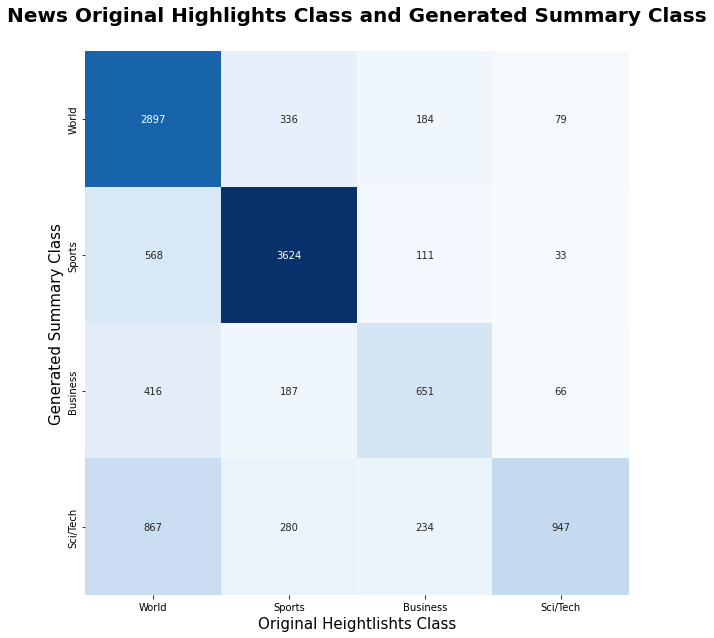

In [40]:
# the confusion matrix heap map for News highlights class and generated summary class(our model)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib

class_lst = ["World","Sports","Business","Sci/Tech"]
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
mat = confusion_matrix(our_model_class, original_class)
sns.heatmap(mat.T, square = True, annot =True, cmap='Blues', fmt ='d', cbar =False,xticklabels = class_lst, yticklabels = class_lst)
plt.xlabel('Original Heightlishts Class',fontsize = 15)
plt.ylabel('Generated Summary Class',fontsize = 15)
plt.title('News Original Highlights Class and Generated Summary Class',fontsize = 20, fontweight='bold',pad=30)
plt.show()

### Get News summary by compared text summarization model and get the News class of summaries generated by the compared model.

In [ ]:
Get News class of our model generated summary by classification model finetuned before

In [12]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer2 = AutoTokenizer.from_pretrained("eslamxm/mt5-base-finetuned-en-cnn")

model2 = AutoModelForSeq2SeqLM.from_pretrained("eslamxm/mt5-base-finetuned-en-cnn")

Downloading:   0%|          | 0.00/408 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [ ]:
model2.to(device)

In [14]:
def batch_data2(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    lst = []
    l = len(data)//bsize
    for i in range(l):
        batch_text = data['article'][bsize*i:bsize*(i+1)].tolist()
        X = tokenizer2.batch_encode_plus(batch_text, truncation =True, padding= 'max_length',max_length = 512, add_special_tokens=True, return_tensors='pt')
        lst.append((X))
    return lst

In [38]:
b_3 = batch_data2(df_3,bsize=8)

In [39]:
d3_lst = []
with tqdm(total=len(b_3)) as process_bar:
  for item in b_3:
    summary_ids = model2.generate(item['input_ids'].to(device),min_length=0,max_length=30)
    tmp=tokenizer2.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    d3_lst.append(tmp)
    process_bar.update(1)

100%|██████████| 291/291 [05:46<00:00,  1.19s/it]


In [40]:
d3_lst_new = []
for item in d3_lst:
  d3_lst_new = d3_lst_new +item

In [15]:
def batch_data3(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    lst = []
    l = len(data)//bsize
    for i in range(l):
        batch_text = data[bsize*i:bsize*(i+1)]
        X = tokenizer.batch_encode_plus(batch_text, truncation =True, padding= 'max_length',max_length = max_len, add_special_tokens=True, return_tensors='pt')
        #Y = torch.LongTensor(data['label'][bsize*i:bsize*(i+1)].tolist())
        #s = batch_text
        lst.append((X))
    return lst

In [42]:
df3_new_batches = batch_data3(d3_lst_new, bsize=batch_size)

In [43]:
df3_new_label =pred_label(df3_new_batches)

In [45]:
b_2 = batch_data2(df_2,bsize=8)

d2_lst = []
with tqdm(total=len(b_2)) as process_bar:
  for item in b_2:
    summary_ids = model2.generate(item['input_ids'].to(device),min_length=0,max_length=30)
    tmp=tokenizer2.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    d2_lst.append(tmp)
    process_bar.update(1)

d2_lst_new = []
for item in d2_lst:
  d2_lst_new = d2_lst_new +item

100%|██████████| 165/165 [03:15<00:00,  1.19s/it]


In [46]:
df2_new_batches = batch_data3(d2_lst_new, bsize=batch_size)
df2_new_label =pred_label(df2_new_batches)

In [16]:
b_1 = batch_data2(df_1,bsize=8)

In [18]:
d1_lst = []
with tqdm(total=len(b_1)) as process_bar:
    for item in b_1:
        summary_ids = model2.generate(item['input_ids'].to(device),min_length=0,max_length=30)
        tmp=tokenizer2.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        d1_lst.append(tmp)
        process_bar.update(1)
    
d1_lst_new = []
for item in d1_lst:
    d1_lst_new = d1_lst_new +item

100%|██████████| 542/542 [10:45<00:00,  1.19s/it]


In [19]:
df1_new_batches = batch_data3(d1_lst_new, bsize=batch_size)
df1_new_label =pred_label(df1_new_batches)

In [59]:
b_0 = batch_data2(df_0,bsize=8)

d0_lst = []
with tqdm(total=len(b_0)) as process_bar:
  for item in b_0:
    summary_ids = model2.generate(item['input_ids'].to(device),min_length=0,max_length=30)
    tmp=tokenizer2.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    d0_lst.append(tmp)
    process_bar.update(1)

d0_lst_new = []
for item in d0_lst:
  d0_lst_new = d0_lst_new +item

100%|██████████| 437/437 [08:44<00:00,  1.20s/it]


In [60]:
df0_new_batches = batch_data3(d0_lst_new, bsize=batch_size)
df0_new_label =pred_label(df0_new_batches)

In [36]:
df0_new_label = df_0['compare_model_class'].tolist()
df2_new_label = df_2['compare_model_class'].tolist()
df3_new_label = df_3['compare_model_class'].tolist()

In [37]:
compared_model_class = df0_new_label + df1_new_label + df2_new_label + df3_new_label

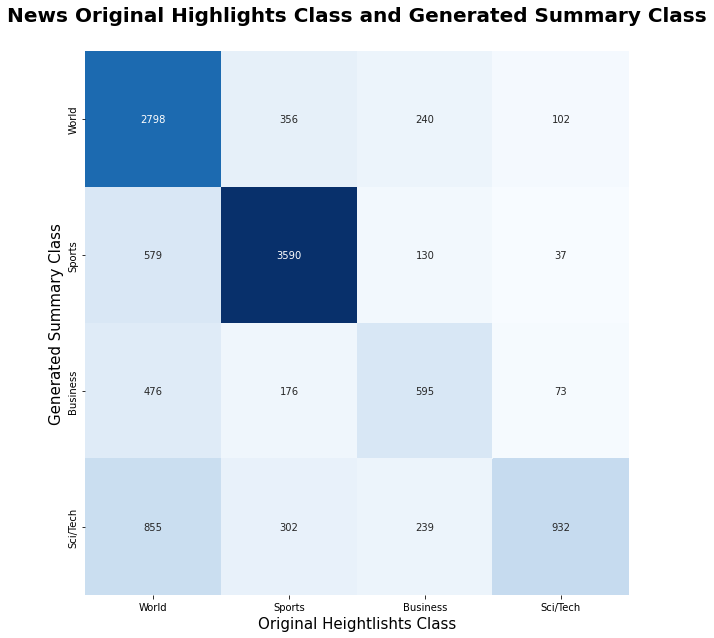

In [41]:
# the confusion matrix heap map for News highlights class and generated summary class(compared model)
class_lst = ["World","Sports","Business","Sci/Tech"]
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10]
mat = confusion_matrix(compared_model_class, original_class)
sns.heatmap(mat.T, square = True, annot =True, cmap='Blues', fmt ='d', cbar =False,xticklabels = class_lst, yticklabels = class_lst)
plt.xlabel('Original Heightlishts Class',fontsize = 15)
plt.ylabel('Generated Summary Class',fontsize = 15)
plt.title('News Original Highlights Class and Generated Summary Class',fontsize = 20, fontweight='bold',pad=30)
plt.show()

In [21]:
#calculate rouge
# define a function
def rouge(predictions,references):
    import evaluate
    rouge = evaluate.load('rouge')
    predictions = predictions
    references = references
    results = rouge.compute(predictions=predictions,references=references)
    results1 = {key: value* 100 for key, value in results.items()}
    return(results1)

In [99]:
print('Our model rouge for class0:')
print(rouge(df_0['summary'], df_0['highlights']))

Our model rouge for class0:
{'rouge1': 26.988156095037752, 'rouge2': 11.879041584014125, 'rougeL': 21.42157639316393, 'rougeLsum': 25.420795575015177}


In [23]:
print('Our model rouge for class1:')
print(rouge(df_1['summary'], df_1['highlights']))

Our model rouge for class1:
{'rouge1': 29.27670857852675, 'rouge2': 13.565294102826048, 'rougeL': 22.865558439204737, 'rougeLsum': 27.73620080549094}


In [98]:
print('Our model rouge for class2')
print(rouge(df_2['summary'], df_2['highlights']))


Our model rouge for class2
{'rouge1': 26.559570940562597, 'rouge2': 12.026978668885747, 'rougeL': 21.399117986306244, 'rougeLsum': 24.926130920537744}


In [97]:
print('Our model rouge for clas3')
print(rouge(df_3['summary'], df_3['highlights']))

Our model rouge for clas3
{'rouge1': 26.227929734333333, 'rouge2': 11.968171415305479, 'rougeL': 20.842424944308686, 'rougeLsum': 24.51391223083973}


In [62]:
df_0['compare_model_summary'] = d0_lst_new
df_1['compare_model_summary'] = d1_lst_new
df_2['compare_model_summary'] = d2_lst_new
df_3['compare_model_summary'] = d3_lst_new

df_0['compare_model_class'] = df0_new_label
df_1['compare_model_class'] = df1_new_label
df_2['compare_model_class'] = df2_new_label
df_3['compare_model_class'] = df3_new_label



In [72]:
df_0['our_model_class'] = df0_result
df_1['our_model_class'] = df1_result
df_2['our_model_class'] = df2_result
df_3['our_model_class'] = df3_result

In [76]:
df_0.to_csv('class0_result.csv',index=False)
df_1.to_csv('class1_result.csv',index=False)
df_2.to_csv('class2_result.csv',index=False)
df_3.to_csv('class3_result.csv',index=False)

In [77]:
from google.colab import files

files.download('/content/class0_result.csv')
files.download('/content/class1_result.csv')
files.download('/content/class2_result.csv')
files.download('/content/class3_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from google.colab import files
files.download('/content/class1_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>